Training τ = 0.05
Training τ = 0.1
Training τ = 0.5
Training τ = 1.0


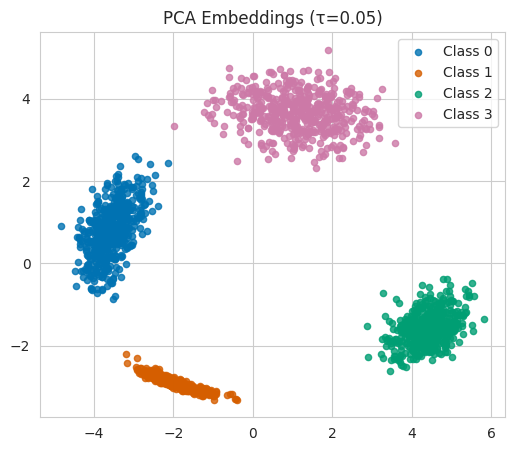

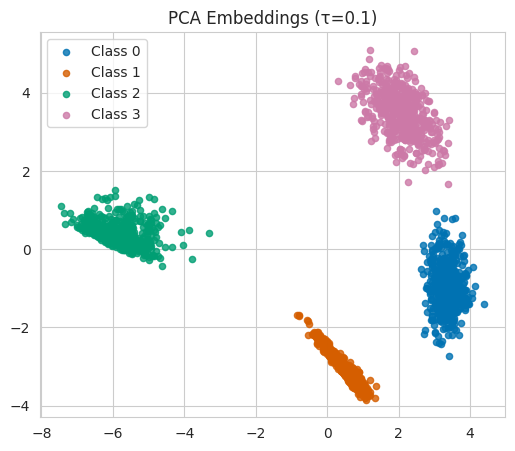

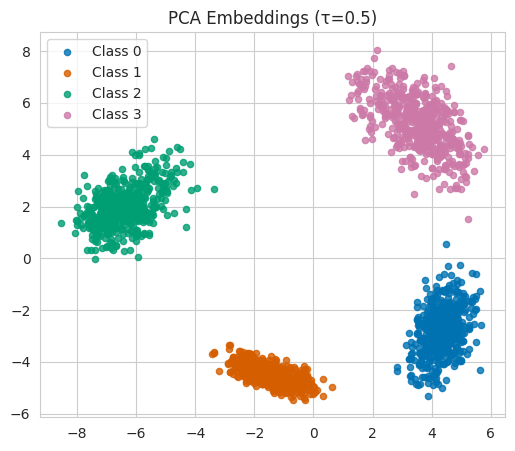

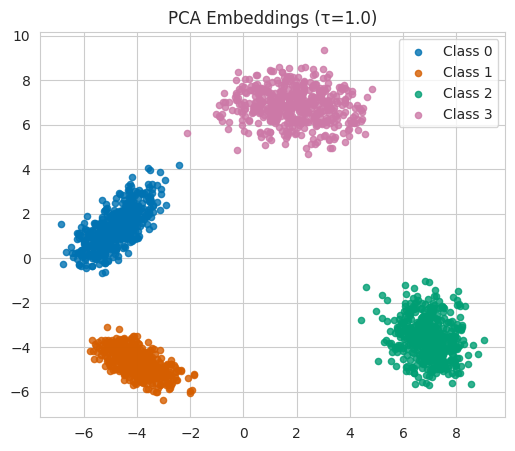

τ = 0.05 → Accuracy = 1.000
τ = 0.1 → Accuracy = 1.000
τ = 0.5 → Accuracy = 1.000
τ = 1.0 → Accuracy = 1.000


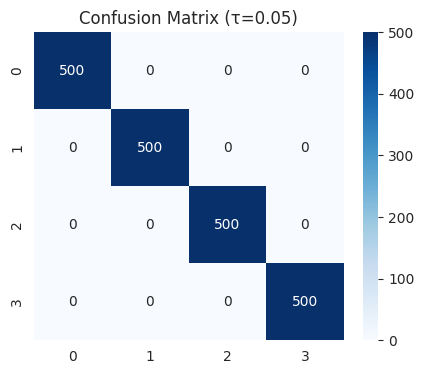

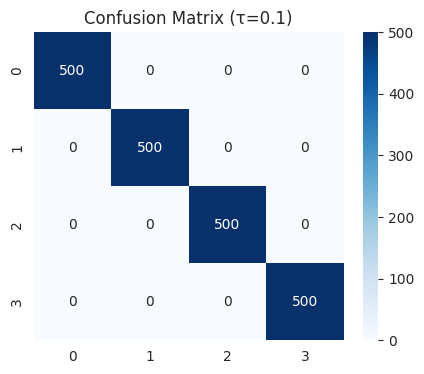

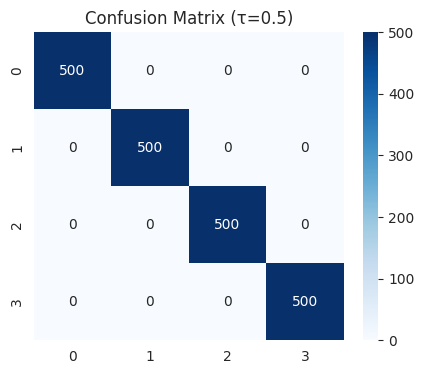

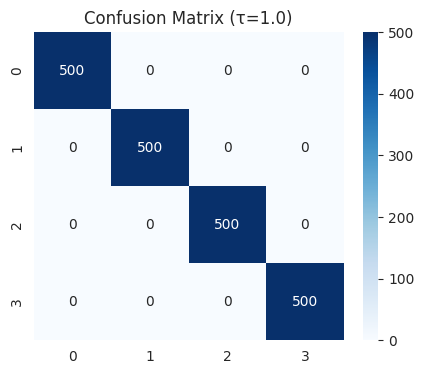

BYOL Accuracy: 1.0


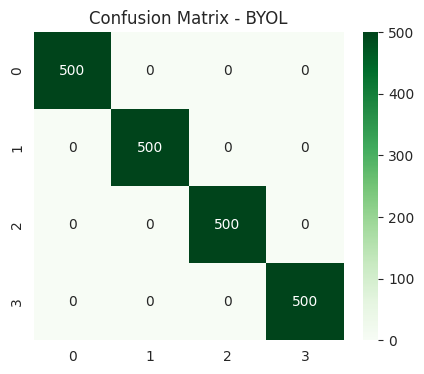

In [1]:
# ==============================================
# TITLE: Self-Supervised Contrastive Learning Tutorial
# TOPIC: SimCLR / MoCo-style queue / BYOL variants
# ==============================================

# -----------------------------
# MARKDOWN: Introduction
# -----------------------------
"""
# Self-Supervised Contrastive Learning (SimCLR, MoCo, BYOL)

This notebook implements a minimal but complete framework to study:
- InfoNCE contrastive loss
- Temperature effects
- Representation collapse
- Embedding visualisation
- Comparison with supervised training
- BYOL-style predictor networks
"""

# ==============================================
# Imports
# ==============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns
sns.set_style("whitegrid")

# Colour-blind safe palette
CB_PALETTE = ["#0072B2", "#D55E00", "#009E73", "#CC79A7"]

# ==============================================
# Synthetic Dataset
# ==============================================
class ContrastiveDataset(Dataset):
    def __init__(self, n_samples=2000, n_classes=4, std=0.8):
        X, y = make_blobs(
            n_samples=n_samples,
            centers=n_classes,
            n_features=2,
            cluster_std=std,
            random_state=42,
        )
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    # SimCLR augmentations
    def transform(self, x):
        noise = torch.randn_like(x) * 0.2
        scale = 0.8 + 0.4 * torch.rand(1)
        return (x + noise) * scale

    def __getitem__(self, idx):
        x = self.X[idx]
        xi = self.transform(x)
        xj = self.transform(x)
        return xi, xj, self.y[idx]


dataset = ContrastiveDataset()
loader = DataLoader(dataset, batch_size=256, shuffle=True)

# ==============================================
# Encoder + Projection Head
# ==============================================
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

class ProjectionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )

    def forward(self, z):
        return self.net(z)

encoder = Encoder()
proj = ProjectionHead()

# ==============================================
# InfoNCE Loss (SimCLR)
# ==============================================
def info_nce_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)

    N = z1.shape[0]
    representations = torch.cat([z1, z2], dim=0)
    sim_matrix = torch.mm(representations, representations.t())

    mask = ~torch.eye(2*N, dtype=bool)

    positives = torch.cat([torch.arange(N), torch.arange(N)], dim=0)
    positives = torch.stack([positives, positives + N], dim=1)

    positive_mask = torch.zeros_like(sim_matrix, dtype=bool)
    for i, j in positives:
        positive_mask[i, j] = True
        positive_mask[j, i] = True

    logits = sim_matrix[mask].view(2*N, -1) / temperature
    positives = sim_matrix[positive_mask].view(2*N, 1) / temperature

    labels = torch.zeros(2*N, dtype=torch.long)
    loss = F.cross_entropy(
        torch.cat([positives, logits], dim=1),
        labels,
    )
    return loss

# ==============================================
# Training Function
# ==============================================
def train_simclr(temperature=0.5, epochs=40):
    encoder_local = Encoder()
    proj_local = ProjectionHead()
    opt = optim.Adam(list(encoder_local.parameters()) + list(proj_local.parameters()), lr=1e-3)

    for ep in range(epochs):
        for x1, x2, _ in loader:
            z1 = proj_local(encoder_local(x1))
            z2 = proj_local(encoder_local(x2))
            loss = info_nce_loss(z1, z2, temperature)
            opt.zero_grad()
            loss.backward()
            opt.step()
    return encoder_local

# ==============================================
# Train several models with different temperatures
# ==============================================
temperatures = [0.05, 0.1, 0.5, 1.0]
models = {}

for t in temperatures:
    print(f"Training τ = {t}")
    models[t] = train_simclr(temperature=t)

# ==============================================
# Extract embeddings for visualisation
# ==============================================
X = dataset.X
y = dataset.y

def get_embeddings(model, X):
    with torch.no_grad():
        return model(X).numpy()

embeddings = {t: get_embeddings(models[t], X) for t in temperatures}

# ==============================================
# PCA Visualisation
# ==============================================
def plot_pca(emb, y, title):
    pca = PCA(n_components=2)
    emb2 = pca.fit_transform(emb)

    plt.figure(figsize=(6,5))
    for cls in np.unique(y):
        idx = y == cls
        plt.scatter(
            emb2[idx,0], emb2[idx,1],
            s=20,
            color=CB_PALETTE[cls % len(CB_PALETTE)],
            label=f"Class {cls}",
            alpha=0.8
        )
    plt.title(title)
    plt.legend()
    plt.show()

for t in temperatures:
    plot_pca(embeddings[t], y, f"PCA Embeddings (τ={t})")

# ==============================================
# Evaluate Linear Classifier on Frozen Embeddings
# ==============================================
def evaluate_embeddings(emb):
    clf = LogisticRegression(max_iter=200)
    clf.fit(emb, y)
    preds = clf.predict(emb)
    return accuracy_score(y, preds), confusion_matrix(y, preds)

results = {}
for t in temperatures:
    acc, cm = evaluate_embeddings(embeddings[t])
    results[t] = (acc, cm)
    print(f"τ = {t} → Accuracy = {acc:.3f}")

# Visualise Confusion Matrices
for t in temperatures:
    acc, cm = results[t]
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix (τ={t})")
    plt.show()

# ==============================================
# OPTIONAL: BYOL-style Stop-Gradient Predictor
# ==============================================
class BYOLPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )
    def forward(self, x):
        return self.net(x)

def byol_loss(p, z):
    z = z.detach()
    p = F.normalize(p, dim=-1)
    z = F.normalize(z, dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1).mean()

# Minimal BYOL training
def train_byol(epochs=40):
    enc = Encoder()
    target_enc = Encoder()
    predictor = BYOLPredictor()

    opt = optim.Adam(list(enc.parameters()) + list(predictor.parameters()), lr=1e-3)

    for ep in range(epochs):
        for x1, x2, _ in loader:
            z1 = enc(x1)
            z2 = enc(x2)

            p1 = predictor(z1)
            p2 = predictor(z2)

            loss = byol_loss(p1, z2) + byol_loss(p2, z1)

            opt.zero_grad()
            loss.backward()
            opt.step()

            # EMA update of target network
            with torch.no_grad():
                for p, p_t in zip(enc.parameters(), target_enc.parameters()):
                    p_t.data = 0.99 * p_t.data + 0.01 * p.data

    return enc

byol_model = train_byol()

byol_embed = get_embeddings(byol_model, X)
acc_byol, cm_byol = evaluate_embeddings(byol_embed)

print("BYOL Accuracy:", acc_byol)

plt.figure(figsize=(5,4))
sns.heatmap(cm_byol, annot=True, cmap="Greens", fmt="d")
plt.title("Confusion Matrix - BYOL")
plt.show()
